In [1]:
#import
import os
import json
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import cuda
from chainer import optimizers
from chainer import iterators
from chainer import training
from chainer.training import extensions
from chainer import datasets

In [2]:
#def
def load_image(file, augmentation=False, size=(224,224)):
    path='/home/ubuntu/intern-winter-2019/dataset/images/'+file
    img=Image.open(path)
    #３次元配列じゃないのが混ざっているのでとりあえず全部RGBにする
    img=img.convert('RGB')
    w,h=img.size
    w_c, h_c=w//2, h//2
    half_short_side=min(w_c, h_c)
    x0=w_c-half_short_side
    y0=h_c-half_short_side
    x1=w_c+half_short_side
    y1=h_c+half_short_side
    img=img.crop((x0,y0,x1,y1))
    img=img.resize(size)
    img=np.array(img, dtype=np.float32)
    return img

def make_dataset(train_data, test_data, VGG=False):
    train=[]
    test=[]

    for file, label in train_data:
        img=load_image(file, augmentation=False)
        img=img.transpose(2,0,1)
        img=img[::-1]
        train.append((img,label))
        if VGG:
            img-=np.array([103.939, 116.779, 123.68],
                        dtype=np.float32).reshape(3, 1, 1)
    
    for file, label in test_data:
        img=load_image(file, augmentation=False)
        img=img.transpose(2,0,1)
        img=img[::-1]
        if VGG:
            img-=np.array([103.939, 116.779, 123.68],
                        dtype=np.float32).reshape(3, 1, 1)
        test.append((img,label))
        
    return np.array(train), np.array(test)


In [3]:
# class
class L2softmaxDataset(chainer.dataset.DatasetMixin):
    def __init__(self):
        train,test=make_dataset(train_data,test_data)
        self.X=[]
        self.T=[]
        
        for x,t in train:
            self.X.append(x)
            self.T.append(t)
            
        self.X = np.array(self.X, dtype=np.float32)
        self.T = np.array(self.T, dtype=np.int32)

    def __len__(self):
        return len(self.T)
    
    def get_example(self, i):
        x=self.X[i].reshape(3,224,224)
        t=self.T[i]
        
        return x, t

class Model(chainer.Chain):
    def __init__(self, dim=2):
        super(Model, self).__init__()
        with self.init_scope():
            self.vgg=L.VGG16Layers()
            self.fc=L.Linear(None, dim)
            
    def __call__(self, x, train=False):
        with chainer.using_config('train', train):
            h=self.vgg(x, layers=['fc7'])['fc7']
            h=F.normalize(h)*50
            y=self.fc(h)
        return y
    
class SoftMaxEntoropyLoss(chainer.Chain):
    def __init__(self, model):
        super(SoftMaxEntoropyLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, t):
        y = self.model(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        summary = F.classification_summary(y, t, beta = 1.0)
        precision = summary[0]
        recall = summary[1]
        f_value = summary[2]
        precision_dict=dict(('precision_%d' % i, val) for i, val in enumerate(summary[0]))
        recall_dict=dict(('recall_%d' % i, val) for i, val in enumerate(summary[1]))
        f_value_dict=dict(('f_value_%d' % i, val) for i, val in enumerate(summary[2]))
        main_dict={'loss':loss, 'accuracy':accuracy}
        main_dict.update(precision_dict)
        main_dict.update(recall_dict)
        main_dict.update(f_value_dict)
        chainer.report(main_dict, self)
        return loss

In [4]:
# データの読み込み
with open ('/home/ubuntu/intern-winter-2019/dataset/train.json') as f:
    train_df=json.load(f)

with open('/home/ubuntu/intern-winter-2019/dataset/test.json') as f:
    test_df=json.load(f)

train_data=[]
test_data=[]

for k0, v0 in train_df.items():
    for k1, v1 in train_df[k0].items():
        for file in train_df[k0][k1]['images']:
            file=file+'.jpg'
            if k0=='cat':
                train_data.append([file, 1])
            else:
                train_data.append([file, 0])
for k0, v0 in test_df.items():
    for k1, v1 in test_df[k0].items():
        for file in test_df[k0][k1]['images']:
            file=file+'.jpg'
            if k0=='cat':
                test_data.append([file, 1])
            else:
                test_data.append([file, 0])
                
train_data=np.array(train_data)
test_data=np.array(test_data)

In [5]:
# VGG16の初期化 modelの作成
vgg = L.VGG16Layers()

In [6]:
model=Model()
loss=SoftMaxEntoropyLoss(model)

In [7]:
# datasetの作成
train,test=make_dataset(train_data,test_data)

In [8]:
dataset=L2softmaxDataset()

In [9]:
n_epoch = 3
batchsize = 32
out_dir = './result/'
report_interval = (10, 'iteration')

train_iter = iterators.MultithreadIterator\
(dataset, batchsize, repeat=True, shuffle=True)
test_iter = iterators.MultithreadIterator\
(dataset, batchsize, repeat=False, shuffle=False)

In [10]:
#fine tuningなのでMomentumSDG
optimizer = chainer.optimizers.MomentumSGD(lr=1e-4)
optimizer.setup(loss)

In [11]:
#device=0でGPU, device=-1でCPU
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [13]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 
                                       'iteration', 
                                       'main/loss',
                                       'main/accuracy', 
                                       'main/precision_0', 
                                       'main/precision_1',
                                       'main/recall_0',
                                       'main/recall_1']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', 
                                     trigger=report_interval, 
                                     file_name='vgg16_loss_plot.png'))
trainer.extend(extensions.PlotReport(y_keys='main/accuracy', 
                                     trigger=report_interval, 
                                     file_name='vgg16_accuracy_plot.png'))

In [14]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  main/precision_0  main/precision_1  main/recall_0  main/recall_1
0           10          0.315586    0.871875       nan               0.943952          0.166667       0.915172       
0           20          0.0539174   0.98125        nan               0.98125           nan            1              
0           30          0.0710644   0.978125       nan               0.978125          nan            1              
0           40          0.119623    0.946875       nan               0.946472          nan            1              
0           50          0.0338599   0.98125        nan               0.98125           nan            1              
0           60          0.024872    0.996875       nan               0.996774          nan            1              
1           70          0.0156976   1              nan               1                 nan            1              
1           80          0.0157769   0.996875       nan    

In [15]:
X = []
T = []
for x, t in test:
    #if t != 0 and np.random.random() > 0.01:
    #    continue
    X.append(x)
    T.append(t)

X = cp.array(X,dtype=np.float32).reshape(-1, 3, 224, 224)
T = np.array(T,dtype=np.int32)

In [16]:
# save
chainer.serializers.save_npz('./intern2019_finetune.model_1', model)

In [17]:
Y=[]
for i in range(len(X)):
    Y.append([model(X[i].reshape(1,3,224,224)).data[0][0],model(X[i].reshape(1,3,224,224)).data[0][1]])
Y=np.array(Y)

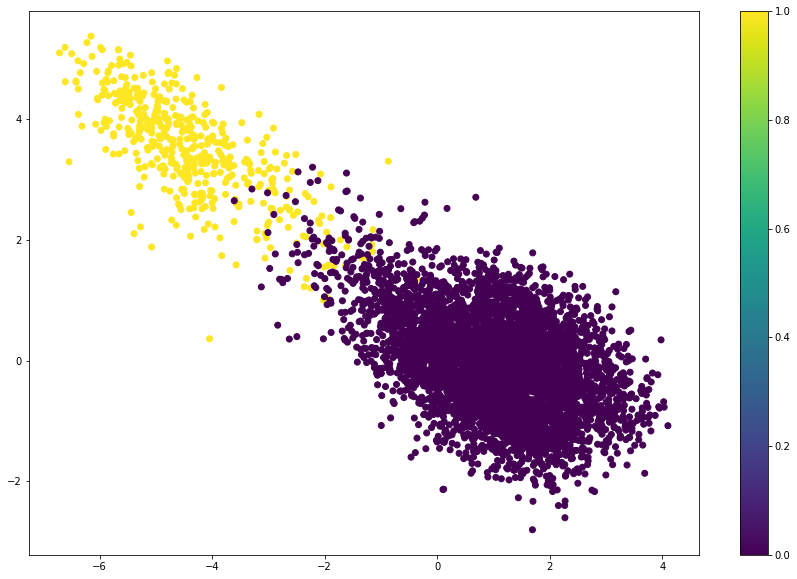

In [18]:
plt.figure(figsize=(15, 10))
plt.scatter(Y[:,0], Y[:,1],c=T)
plt.colorbar()

In [19]:
Y_label=[]
for _ in Y:
    flag=True
    if _[0]>_[1]:
        flag=False
    Y_label.append(flag)

In [20]:
Y_label=np.array(Y_label)

In [21]:
T_label=[T==1][0]

In [22]:
T_label

array([ True,  True,  True, ..., False, False, False])

In [23]:
cnt=0
for i in range(len(T==1)):
    if Y_label[i]==T_label[i]:
        cnt+=1
(cnt-475)/len(T==1)

0.6891490152359717

In [24]:
from sklearn import cluster

In [32]:
len(T[T==0]) / len(T)

0.9117428465254552

In [26]:
clf=cluster.KMeans(n_clusters=2)

In [27]:
pred=clf.fit_predict(Y)

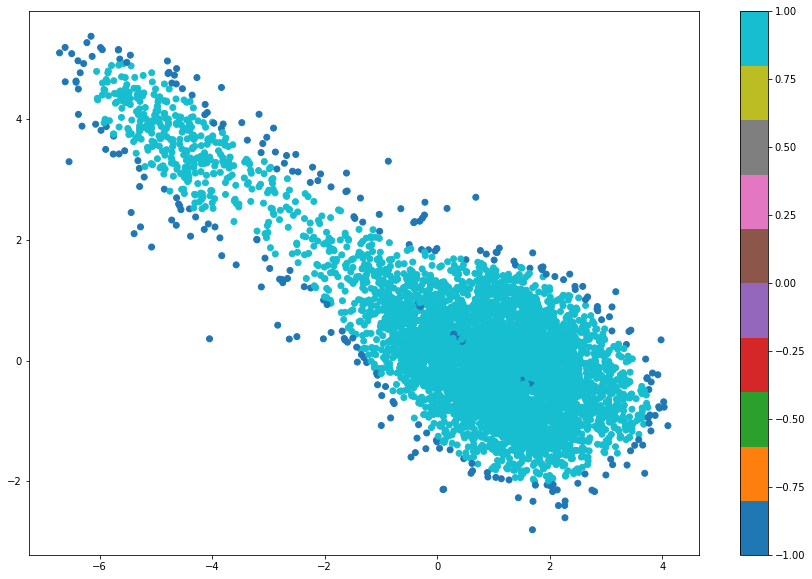

In [53]:
plt.figure(figsize=(15, 10))
plt.scatter(Y[:, 0], Y[:,1], c=pred, cmap='tab10')
plt.colorbar()

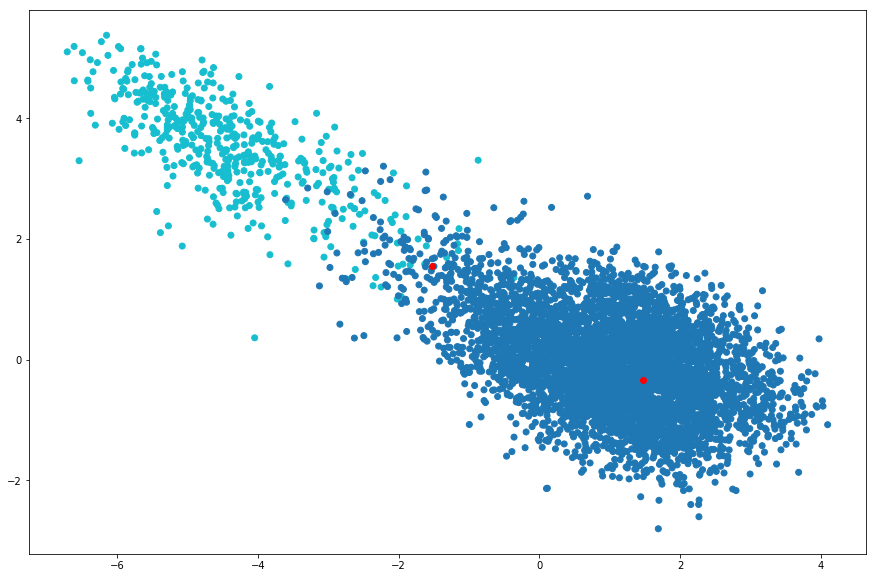

In [55]:
plt.figure(figsize=(15, 10))
plt.scatter(Y[:, 0], Y[:,1], c=T_label, cmap='tab10')
plt.scatter(float(Y[~Y_label][:,0].sum()/len(Y[~Y_label][:,0])),float(Y[~Y_label][:,1].sum()/len(Y[~Y_label][:,1])),c='r')
plt.scatter(float(Y[Y_label][:,0].sum()/len(Y[Y_label][:,0])),float(Y[Y_label][:,1].sum()/len(Y[Y_label][:,1])),c='r')

In [37]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from scipy import stats

In [46]:
clf=svm.OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
clf.fit(Y)
pred=clf.predict(Y)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score